# 1. plot significant electrodes on brain across different frequency bands for all subjects

In [1]:
import numpy as np
from scipy import stats
import os
import scipy.io as scio
import matplotlib.image as mpimg
import matplotlib as mpl
import matplotlib.patches as patches
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

bands_list = ['theta', 'alpha', 'beta1', 'beta2', 'low gamma', 'high gamma']
freq_list=[400]
HS_list=[68, 69, 75, 79, 82, 83, 84, 85, 86]

In [2]:
from statsmodels.stats.multitest import multipletests

def adjust_p_values(p_values, method='fdr_bh'):
    """
    对 p 值进行多重检验矫正。
    参数:
    - p_values: numpy.ndarray, 原始 p 值数组，形状为 (n_electrodes, n_times)。
    - method: str, 多重检验方法，默认为 'fdr_bh'。
    返回:
    - adjusted_p_values: numpy.ndarray, 矫正后的 p 值，形状与输入相同。
    """
    n_electrodes, n_times = p_values.shape
    adjusted_p_values = np.full_like(p_values, np.nan)  # 初始化矫正后的 p 值数组

    for time_idx in range(n_times):
        time_p_values = p_values[:, time_idx]
        valid_mask = ~np.isnan(time_p_values)  # 筛选有效 p 值
        if np.any(valid_mask):
            # 对当前时间点的 p 值进行多重检验矫正
            _, adj_pvals, _, _ = multipletests(time_p_values[valid_mask], method=method)
            adjusted_p_values[valid_mask, time_idx] = adj_pvals

    return adjusted_p_values

# from p_value calculate significant electrodes
#  if an electrode has continus 40 timestpes with p_value<0.05, we select this electrode as significant electrode
def get_significant_electrodes_with_continuity(p_values_dict, threshold=0.01, min_continuous_points=80):
    """
    获取显著电极的索引列表，基于连续显著时间点的数量。
    Args:
        p_values_dict (dict): 每个频段的p值数据，形如 {band: p_values_array}。
        threshold (float): 显著性阈值。
        min_continuous_points (int): 连续显著时间点的最小数量。
    Returns:
        dict: 每个频段显著电极的索引列表 {band: significant_indices_list}。
    """
    significant_electrodes = {}
    for band, p_values in p_values_dict.items():
        significant_indices = []
        adjusted_p_values = adjust_p_values(p_values, method='fdr_bh')
        for electrode_idx in range(adjusted_p_values.shape[0]):
            # 找出该电极的显著时间点
            significant_mask = adjusted_p_values[electrode_idx, :] < threshold
            # 检查连续显著的时间点数量
            continuous_blocks = np.diff(np.where(np.concatenate(([0], significant_mask, [0])))[0]) - 1
            if np.any(continuous_blocks >= min_continuous_points):
                significant_indices.append(electrode_idx)
        significant_electrodes[band] = significant_indices
    return significant_electrodes

In [3]:
base_path = '/public/DATA/overt_reading/Blocked_data/'  # 数据基础路径
save_base_path = '/public/DATA/overt_reading/t-test_results/'
for HS in HS_list:
    os.makedirs(os.path.join(save_base_path, f'{HS}HS'), exist_ok=True)
    p_values = np.load(os.path.join(save_base_path, f'HS{HS}/allband_p_values.npy'), allow_pickle=True).item()
    significant_electrodes = get_significant_electrodes_with_continuity(p_values)
    np.save(os.path.join(save_base_path, f'HS{HS}/allbands_sigelecs.npy'), significant_electrodes)

In [6]:
def load_all_subjects_sigelecs(HS_list, freq_list, band):
    all_coords, all_HS, all_anatomy, all_elecs = [], [], [], []
    path = '/public/DATA/overt_reading/'

    for HS in HS_list:
        anatomy = scio.loadmat(path+f"/elecs/All_elecs/HS{HS}_elecs_all_warped.mat")['anatomy']

        for freq in freq_list:
            save_sigelecs_path = f'/public/DATA/overt_reading/t-test_results/HS{HS}/'
            bands_sigelecs = np.load(os.path.join(save_sigelecs_path, 'allbands_sigelecs.npy'), allow_pickle=True).item()
            band_sigelecs = bands_sigelecs[band]
            subject_str = f"HS{HS}"
            
            # Load 3D electrode coordinates in MNI space
            path = '/public/DATA/overt_reading/'
            coords = scio.loadmat(path + f"/elecs/All_elecs/{subject_str}_warped_elec_pos2D.mat")['elecmatrix']

            for i, sigelecs in enumerate(band_sigelecs):
                all_coords.append(coords[sigelecs])  # Append each electrode's coordinates
                all_HS.append(HS)        # Append each electrode's HS
                all_anatomy.append(anatomy[sigelecs][3][0])
                all_elecs.append(sigelecs)

    return np.array(all_coords), np.array(all_HS), np.array(all_anatomy), np.array(all_elecs)

def plot_brain_surface_with_sigelecs(all_coords, all_HS, all_anatomy, all_elecs, band, view_2D=True):
    # Load 2D brain image
    path = '/public/DATA/overt_reading/'
    img = mpimg.imread(path +"/elecs/Brain2D/MNI152_brain2D.png")
    marker_type = {}
    marker_type["68"] = "D"
    marker_type["69"] = "*"
    marker_type["75"] = "s"
    marker_type["79"] = "P"
    marker_type["82"] = "o"
    marker_type["83"] = "v"
    marker_type["84"] = "^"
    marker_type["85"] = "X"
    marker_type["86"] = "p"

    color_set_region = {'superiorfrontal': 'grey',
             'superiortemporal': 'purple',
             'inferiorparietal': 'skyblue',
             'rostralmiddlefrontal': 'black',
             'parstriangularis': 'darkgreen',
             'superiorparietal': 'orange',
             'postcentral': 'red',
             'parsopercularis': 'gold',
             'middletemporal': 'greenyellow',
             'inferiortemporal': 'pink',
             'parsorbitalis': 'olive',
             'supramarginal': 'green',
             'lateraloccipital': 'navy',
             'bankssts': 'rosybrown',
             'precentral': 'blue',
             'caudalmiddlefrontal': 'slategrey'}
    
    plt.subplots(figsize=(15,15))

    plt.imshow(img)
    for i, elec in enumerate(all_elecs):
        plt.scatter(all_coords[i, 0], all_coords[i, 1], c=color_set_region[all_anatomy[i]], marker=marker_type[str(all_HS[i])], alpha=0.7)
    # plt.scatter(all_coords[:, 0], all_coords[:, 1], alpha=0.7, )
    # 创建虚拟点用于图例
    legend_handles = []
    for region, color in color_set_region.items():
        legend_handles.append(plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=region))
    
    # 添加图例
    plt.legend(handles=legend_handles, title="Brain Regions", loc='upper right', fontsize='small', title_fontsize='medium')

    plt.title(f'Significant Electrodes(p_value<0.01) {band} - number {len(all_elecs)}')
    plt.axis('off')
    plt.show()
    

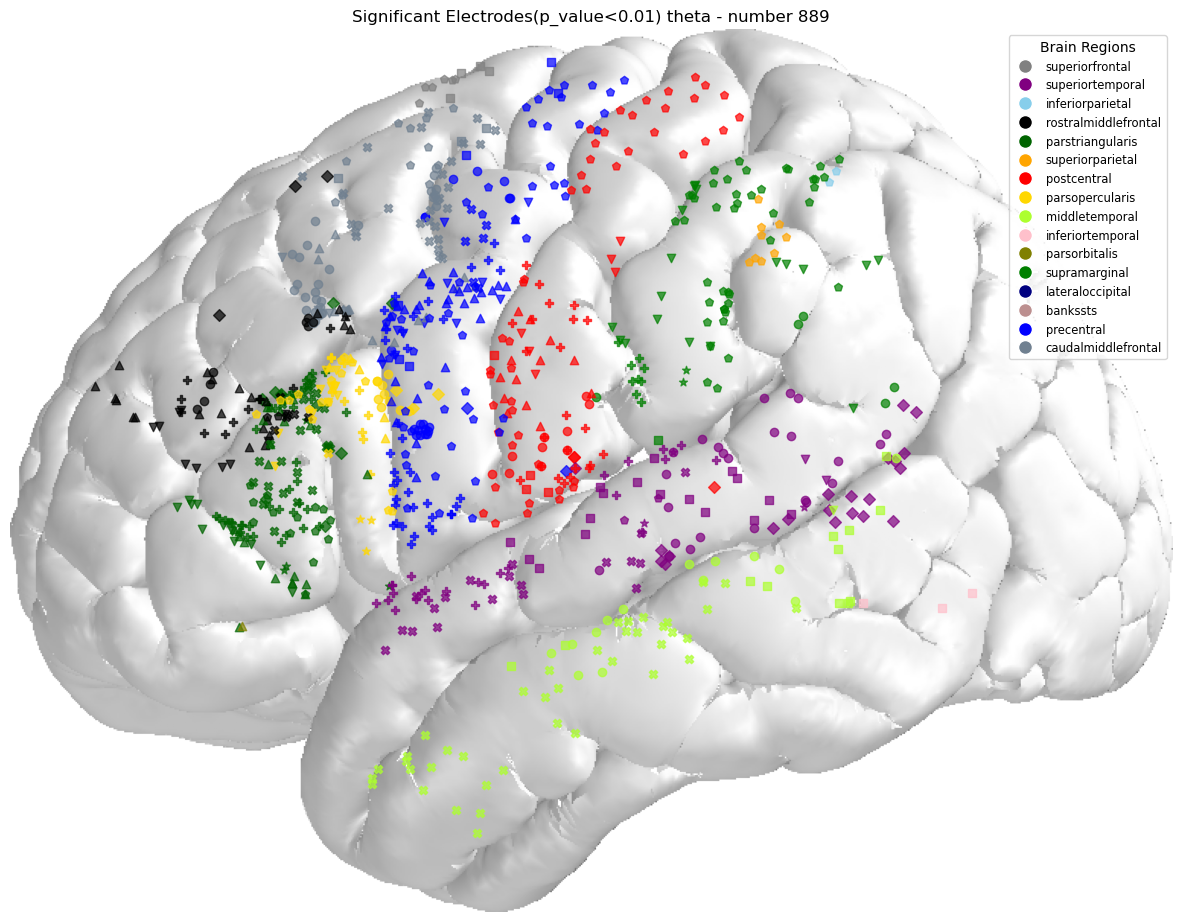

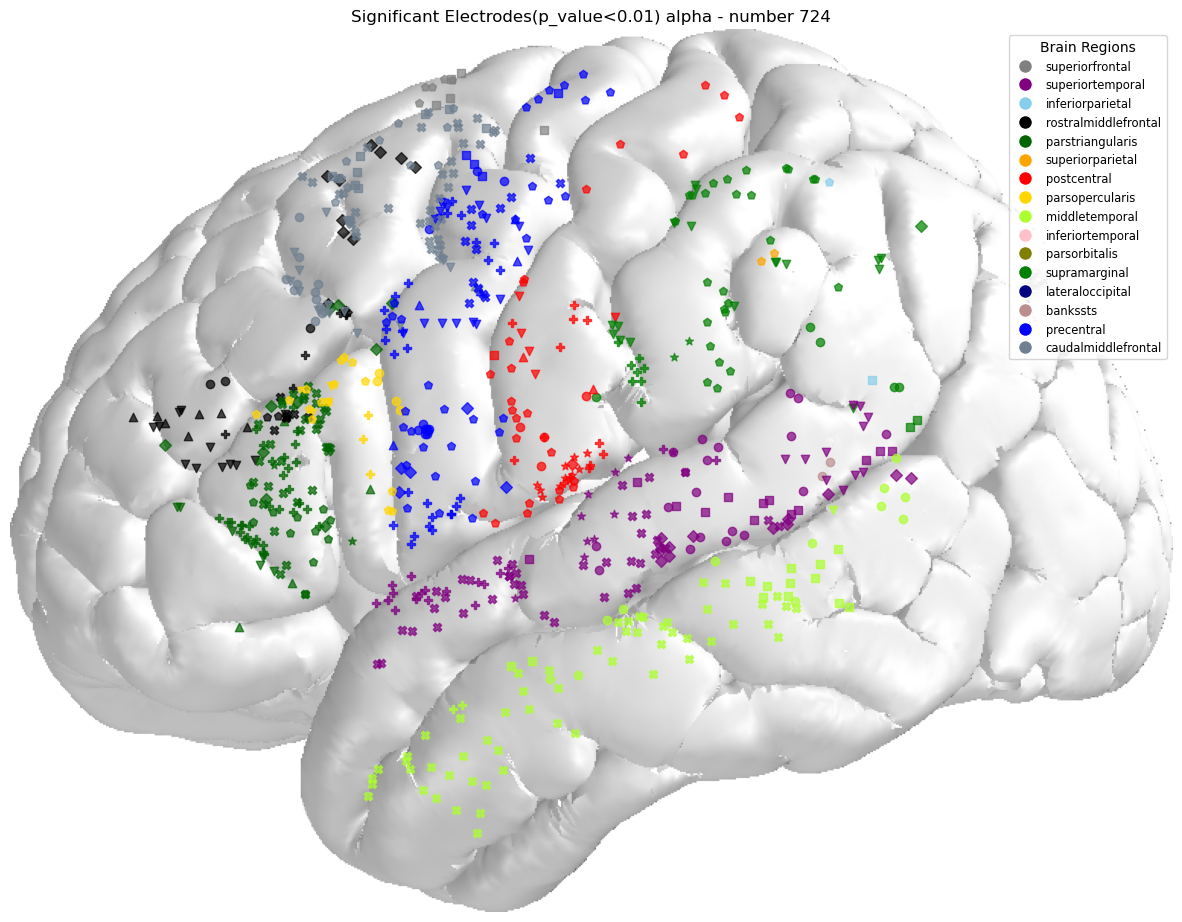

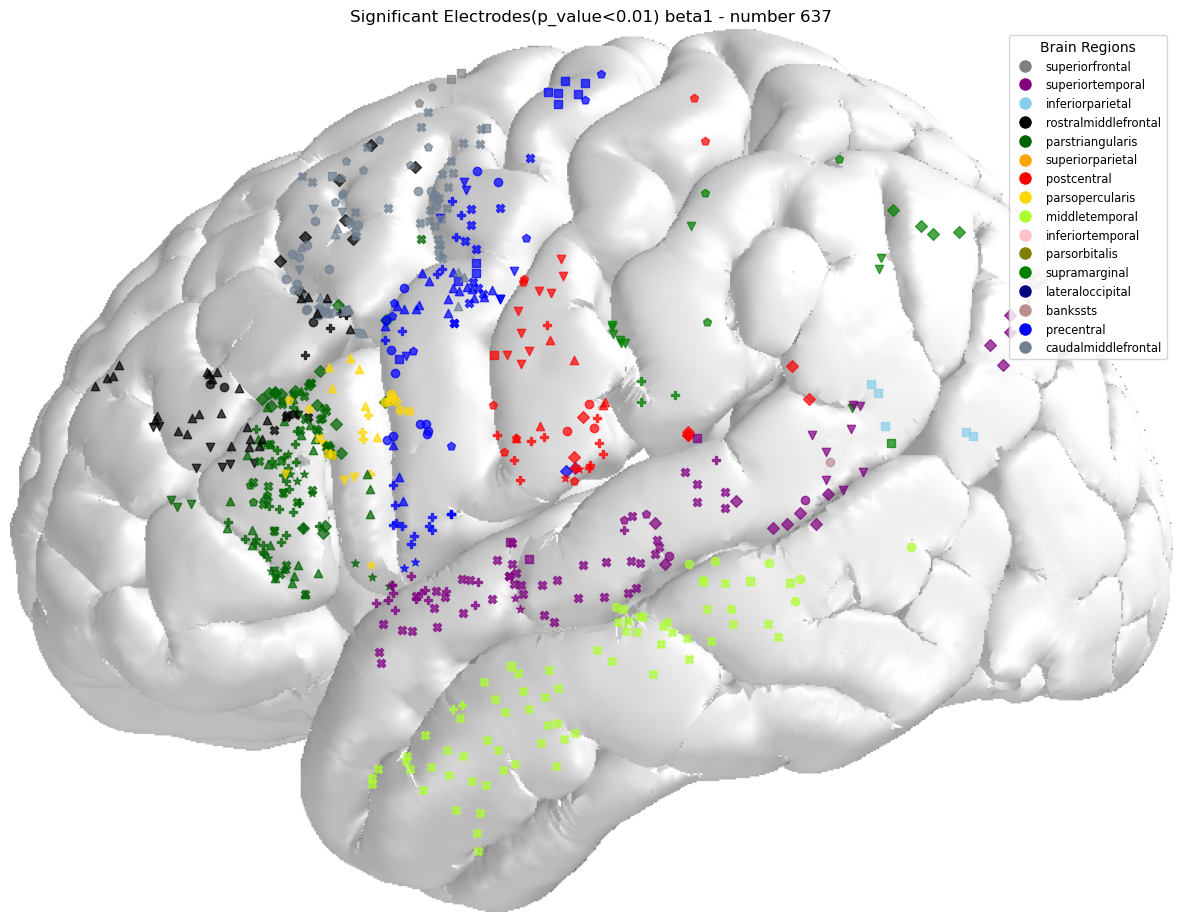

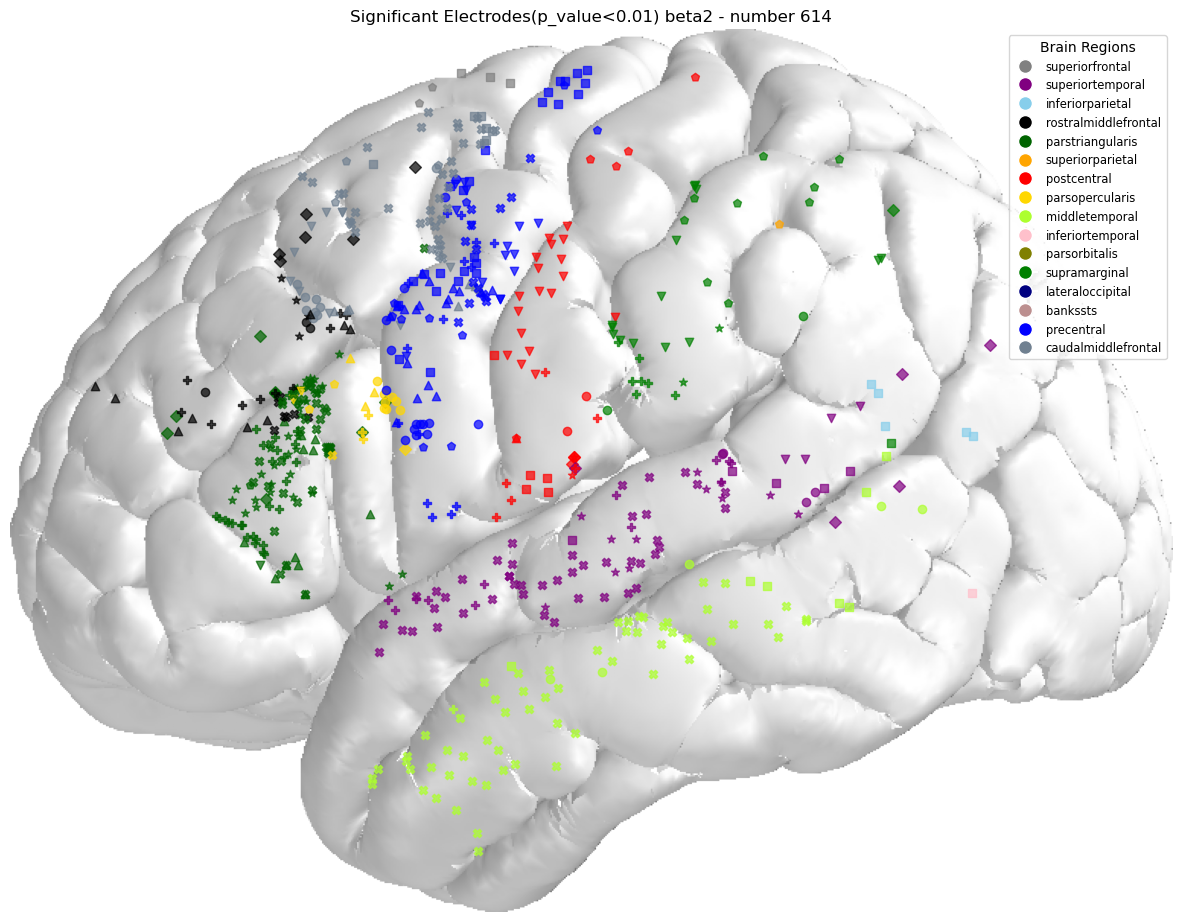

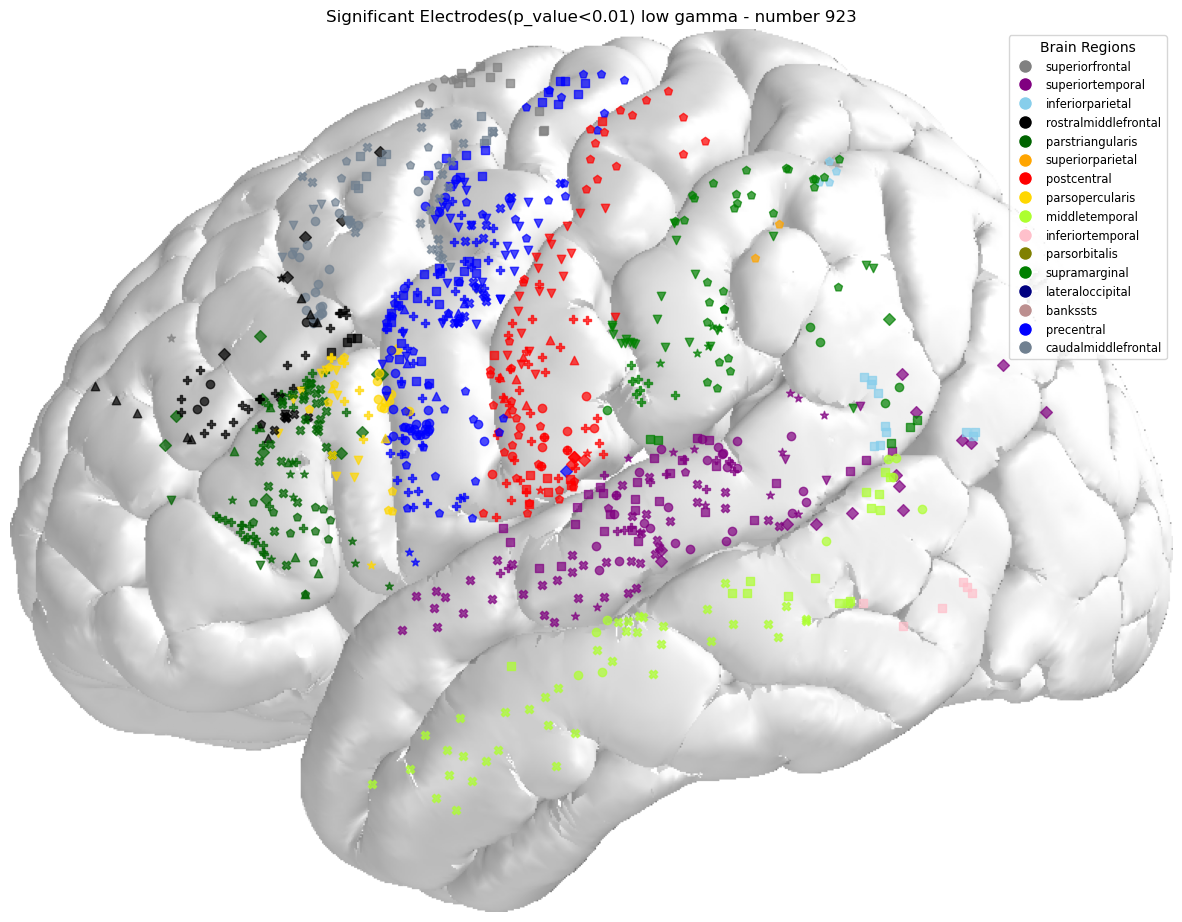

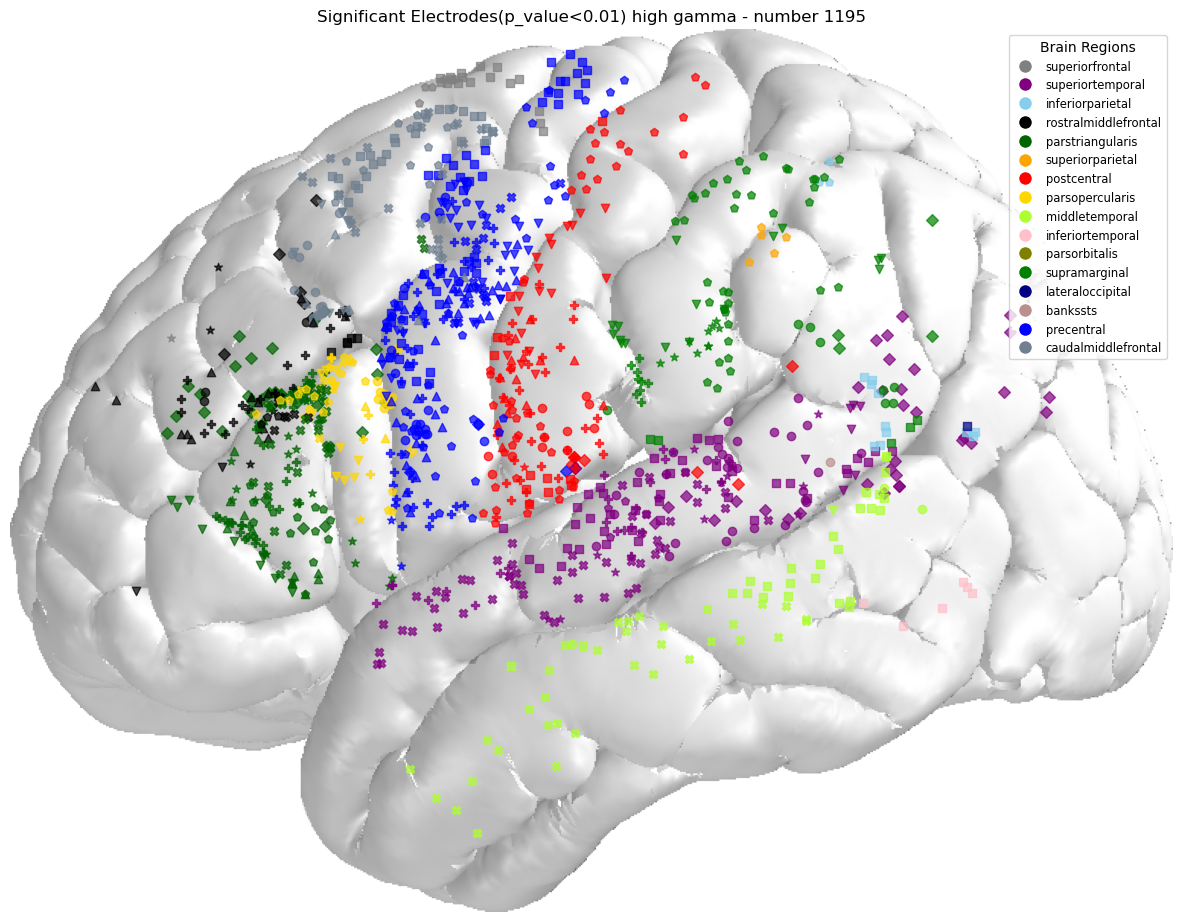

In [8]:
for band in bands_list:
    all_coords, all_HS, all_anatomy, all_elecs = load_all_subjects_sigelecs(HS_list, freq_list, band)
    # Plot accuracy on brain surface
    # plot_brain_surface_with_sigelecs(all_coords, all_values, band, view_2D=True)
    plot_brain_surface_with_sigelecs(all_coords, all_HS, all_anatomy, all_elecs, band, view_2D=True)